In [48]:
import os
import torch
import matplotlib.pyplot as plt 
from pathlib import Path
import numpy as np
from PIL import Image
from torchvision import transforms
from src.explainer import run_grad_cam_on_image, reshape_transform_vit_huggingface
from transformers import ViTImageProcessor, ViTForImageClassification
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from vit_ft import load_dataset

model_name = 'google/vit-base-patch16-224-in21k'
checkpoint = "/mnt/sherlock/oak/cnn_fire_fuel//vit-sweeps-bayes/checkpoint-5470/"

In [29]:
path_test = list(Path("/mnt/sherlock/oak/cnn_fire_fuel/data/test/").rglob("*.png"))
burned = [f for f in path_test if f.stem.split("_")[-1] == "1"]
unburned = [f for f in path_test if f.stem.split("_")[-1] == "0"]

In [30]:
model = ViTForImageClassification.from_pretrained(checkpoint)
image_processor = ViTImageProcessor(model_name)

In [140]:
# 456

image = Image.open(burned[11])
targets_for_gradcam = [ClassifierOutputTarget(1)]
target_layer_dff = model.vit.layernorm
target_layer_gradcam = model.vit.encoder.layer[-2].output

image_resized = image.resize((224, 224))
tensor_resized = image_processor(image_resized, return_tensors="pt")

with torch.no_grad():
    logits = model(**tensor_resized).logits

predicted_label = logits.argmax(-1).item()
print(f"Predicted label: {predicted_label}")


Predicted label: 0


In [141]:
arr =  run_grad_cam_on_image(model=model,
                          target_layer=target_layer_gradcam,
                          targets_for_gradcam=targets_for_gradcam,
                          input_tensor=tensor_resized["pixel_values"].squeeze(),
                          input_image=image_resized,
                          reshape_transform=reshape_transform_vit_huggingface
                          )

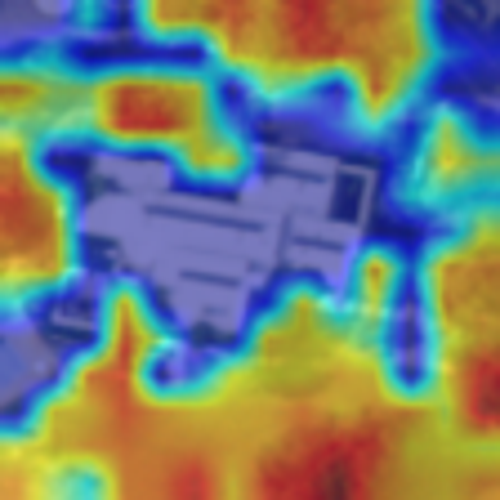

In [142]:
Image.fromarray(arr).resize((500, 500))

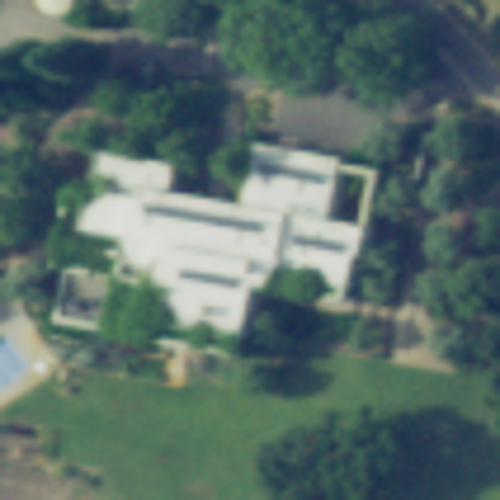

In [143]:
image.resize((500, 500))

In [182]:
from transformers import (
    VisionTextDualEncoderModel,
    VisionTextDualEncoderProcessor,
    AutoTokenizer,
    AutoImageProcessor,
)
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from transformers_interpret import MultiLabelClassificationExplainer

In [184]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)

model =  VisionTextDualEncoderModel.from_pretrained("/mnt/sherlock/scratch/vit-roberta-finetuned-supervised/checkpoint-13700/")

# Read in text data
test_data = pd.read_csv("data/test_data.csv")

# Calculate labels and sample using class weights
test_data["label"] = test_data.image_column.apply(lambda x: x.split("_")[-1].split(".")[0])

weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=test_data.label.astype(int))
weights_col = np.where(np.array(test_data["label"].astype(int)) == 0, weights[0], weights[1])
test_data["weights"] = weights_col

sample_df = test_data.sample(10, weights="weights", replace=True)

In [235]:
embbed.state_dict().keys()

odict_keys(['cls_token', 'position_embeddings', 'patch_embeddings.projection.weight', 'patch_embeddings.projection.bias'])

In [231]:
embbed = list(dict(model.vision_model.base_model.named_children()).values())[0]
dir(embbed)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_is_hf_initialized',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_lo